# Import Libraries

In [5]:
library(rgdal)
library(gdata)
library(ggplot2)
library(dplyr)
library(lubridate)
library(RColorBrewer)
library(extrafont)
library(stringr)

In [6]:
# plot options
options(warn=-1, repr.plot.res = 90) # adjust plot size
theme_set(theme_grey(base_family='NanumGothic'))

# Load Data

In [7]:
# 빅콘 - 챔피언스 리그
# ns 홈쇼핑 2019 매출 데이터 및 시청률 데이터 & 2020년 6월 편성표 
hshop.sales <- read.xls("../data/00/2019sales.xlsx", skip = 1, header = TRUE)
hshop.view <- read.xls("../data/00/2019vrating.xlsx", skip = 1, header = TRUE)
hshop.test <- read.xls("../data/00/202006schedule.xlsx", header = TRUE)


In [8]:

# define column data type 
hshop.sales$방송일시 <- as.POSIXct(hshop.sales$방송일시)
hshop.sales$month <- as.factor(month(hshop.sales$방송일시))
hshop.sales$day <- as.factor(day(hshop.sales$방송일시))
hshop.sales$hour <- as.factor(hour(hshop.sales$방송일시))
hshop.sales$weekday <- factor(weekdays(hshop.sales$방송일시), levels = c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))
hshop.sales$sales <- as.numeric(gsub(",", "", hshop.sales$취급액))
hshop.sales$판매단가 <- as.numeric(gsub(",", "", hshop.sales$판매단가))
hshop.sales$volume <- as.numeric(hshop.sales$sales)/as.numeric(hshop.sales$판매단가)

### 월일별 평균 매출 

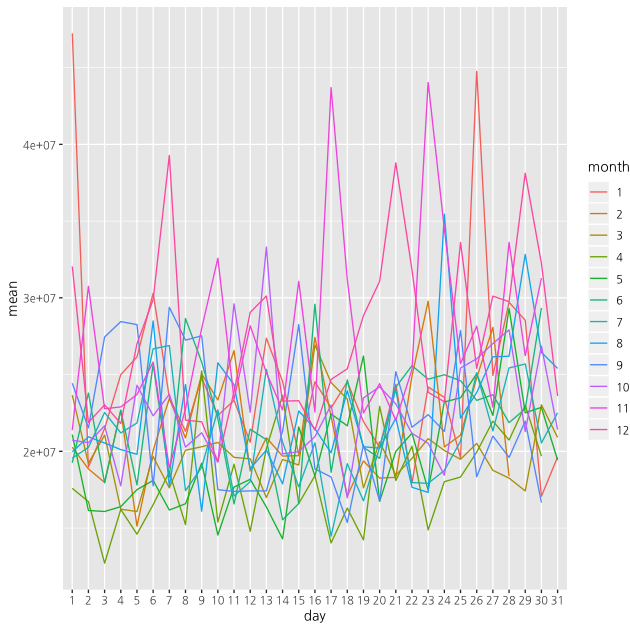

In [11]:
#monthly
md.sales = hshop.sales %>%
  group_by(month, day) %>%
  summarize(mean = mean(sales, na.rm = TRUE))
ggplot(md.sales, aes(x=day,y=mean,group=month))+
  geom_line(aes(color = month))

### 요일별 평균매출

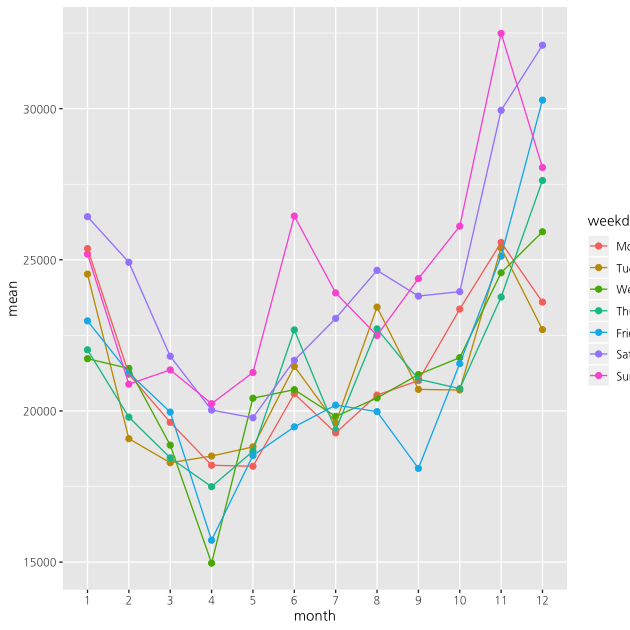

In [23]:
# 기본적으로 주말에 매출량이 많음
# 1,6,11월 정도가 피크
# 4월달에는 전체적으로 감소 --> 야외활동 영향?

# 평균매출액 기준
hshop.sales %>%
  group_by(month,weekday) %>%
  summarize(mean=mean(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=weekday,color=weekday)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 


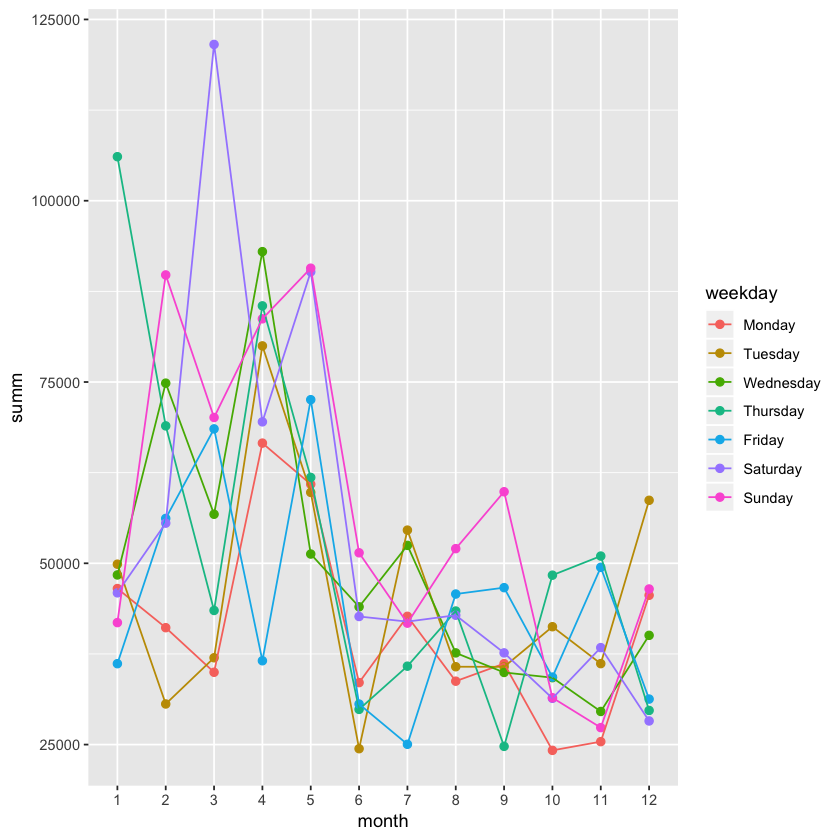

In [18]:
# 판매량합 기준
hshop.sales %>%
  group_by(month,weekday) %>%
  summarize(summ=sum(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=summ,group=weekday,color=weekday)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 

평균매출액 기준으로 보면 4월의 평균매출액이 제일 낮고 11월부터 겨울 기간의 평균매출액이 제일 높은데
판매수량 기준으로 보면 오히려 3-5월이 높은 걸 확인할 수 있음 --> 판매품목의 차이?

### 품목별 월별 판매수량

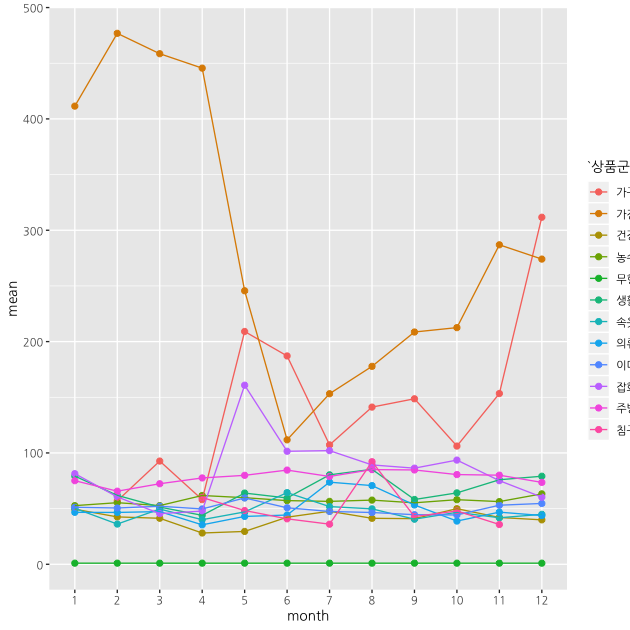

In [21]:
#by category+monthly
hshop.sales %>%
  group_by(상품군, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5)  


### 평일 시간대별 판매 수량

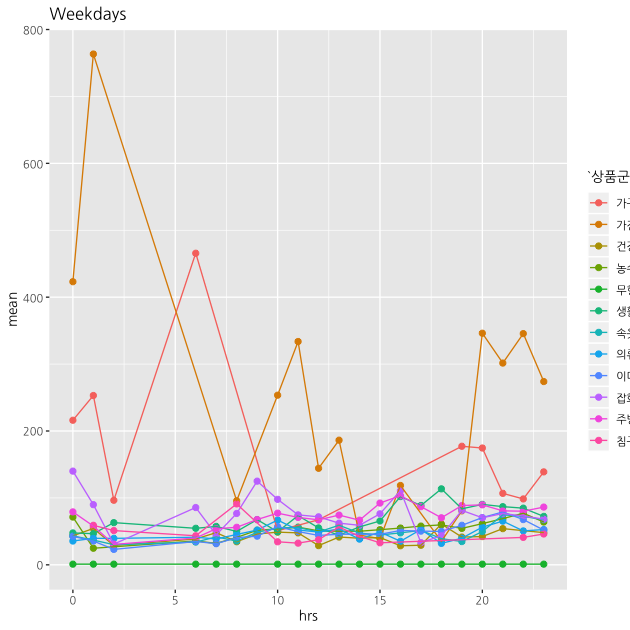

In [26]:
#by category+monthly
weekends <- c("Saturday", "Sunday")
hshop.sales %>%
  filter(!(weekday %in% weekends)) %>%
  mutate(hrs = hour(방송일시))%>%
  group_by(상품군, hrs) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=hrs,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekdays")

### 주말 시간대별 판매 수량

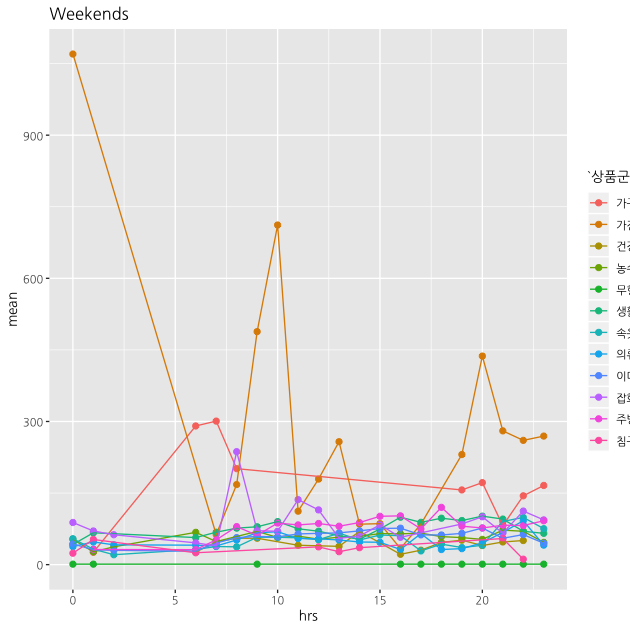

In [27]:

hshop.sales %>%
  filter((weekday %in% weekends)) %>%
  mutate(hrs = hour(방송일시))%>%
  group_by(상품군, hrs) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=hrs,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekends")


### 건강기능 품목 월별 평균 매출액 - 계절성 확인

상품명,mean
닥터 슈퍼 루테인,36466.33
제주농장 유기 양배추진액 120포,20711.12
종근당건강 프로메가 오메가3 파워,22666.83
통째로 착즙한 루비 석류즙 84포,41276.12
특집 이롬 황성주1일1생식 스페셜,10816.50


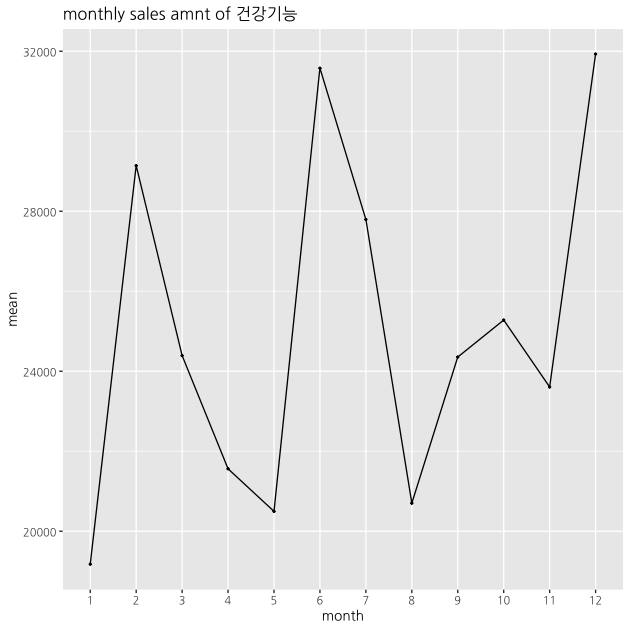

In [28]:

hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  filter(상품군 == "건강기능") %>%
  group_by(month) %>%
  summarize(mean=mean(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean)) + 
  geom_point(size=0.5) +
  geom_line(aes(group = 1)) +
  ggtitle("monthly sales volume of 건강기능")

# 10월 건강기능 식품 판매목록
hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  filter((상품군 == "건강기능") & (month == 2))  %>%
  group_by(상품명) %>%
  summarize(mean=mean(sales, na.rm = TRUE))  
#6,7월 여름에 다이어트 구미, 유산균 판매량 높음
#전반적으로 유산균, 루테인 판매율이 높음 - 네이버 인기 키워드와 유사

###  방송횟수

eda/featureEng1 참고

상품군,count
가구,2614
가전,6479
건강기능,790
농수축,3884
무형,937
생활용품,2877
속옷,3919
의류,4340
이미용,1305
잡화,3891


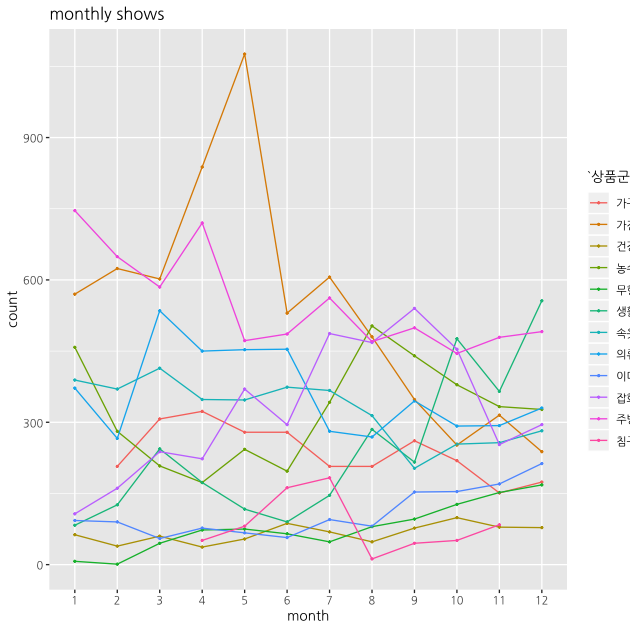

In [29]:
# 방송횟수
hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  group_by(상품군) %>%
  summarize(count=n())

# 방송횟수
hshop.sales %>%
  select(month, 상품명, 상품군, volume, sales) %>%
  group_by(month, 상품군) %>%
  summarize(count=n()) %>%
  ggplot(aes(x=month,y=count,group=상품군,color=상품군)) + 
  geom_point(size=0.5) +
  geom_line() +
  ggtitle("monthly shows")

### 매출액 기준 인기상품 리스트

In [30]:
hot.items <- hshop.sales %>%
      group_by(마더코드) %>%
      summarize(summ=sum(sales, na.rm = TRUE)) %>%
      arrange(desc(summ)) %>%
      head(5) %>% # Top 5
      select(마더코드) %>%
      as.list()
# 1   100148 26362488
# 2   100074 22559131
# 3   100155 20301638
# 4   100837 20112241
# 5   100150 18940818
hshop.sales %>%
    select(month, 상품명, 상품군, volume, sales, 마더코드) %>%
    filter(마더코드 %in% hot.items$마더코드)  %>%
    group_by(마더코드) %>%
    mutate(mean = mean(sales, na.rm = TRUE)) %>%
    filter(row_number()==1) %>%
    select(상품명, 마더코드, mean) 

상품명,마더코드,mean
비버리힐스폴로클럽 남성기초세트(2018FW골드),100074,46227.73
일시불 LG 통돌이 세탁기,100150,31358.97
일시불 LG전자 매직스페이스 냉장고,100155,32744.58
일시불 LG 울트라HD TV 55UK6800HNC,100148,10069.71
(도냄)무이자 쿠쿠전기밥솥 10인용,100837,13345.88


### 판매수량별 인기상품

업데이트 예정

In [12]:
#hottest items(by volume)
hot.items.amnts <- hshop.sales %>%
  group_by(마더코드) %>%
  summarize(summ=sum(volume, na.rm = TRUE)) %>%
  arrange(desc(summ)) %>%
  head(5) %>%
  select(마더코드) %>%
  as.list()

hshop.sales %>%
    select(month, 상품명, 상품군, volume, sales, 마더코드) %>%
    filter(마더코드 %in% hot.items.amnts$마더코드)  %>%
    group_by(마더코드) %>% 
    mutate(sum=sum(volume, na.rm = TRUE)) %>%
    filter(row_number()==1) %>%
    select(상품명, 마더코드, sum) %>%
    as.list()

$상품명
[1] 국내산 손질갑오징어 8팩                    
[2] 멋진밥상 흥양농협 햅쌀 20kg                
[3] 비버리힐스폴로클럽 남성기초세트(2018FW골드)
[4] 안동간고등어 20팩                          
[5] AAB의 소곱창전골 800g x 8팩                
1770 Levels:   뉴트리원 다이어트 구미 ...

$마더코드
[1] 100322 100849 100074 100253 100010

$sum
[1] 227206.5 209864.6 566812.3 465758.9 213309.0

attr(,"groups")
# A tibble: 5 x 2
  마더코드 .rows    
     <int> <list>   
1   100010 <int [1]>
2   100074 <int [1]>
3   100253 <int [1]>
4   100322 <int [1]>
5   100849 <int [1]>

### Seasonal items

업데이트 예정

In [73]:
seasonal_items <- scan("seasonal_items.txt", character(), quote = "")

filtering.seasonal <- function(paras){
  
  if(paras[6] == "잡화" & paras[7] > 200000) return("명품잡화")
  else if (str_detect(paras[5], "김치냉장고")) return("김치냉장고")
  else if(str_detect(paras[5], "냉장고")) return("냉장고")
  else if(sum(str_detect(paras[5], c("에어컨","서큘레이터")))>0) return("냉방용품")
  else if(sum(str_detect(paras[5], c("공청기","공기청정기")))>0) return("공기청정기")
  else if(str_detect(paras[5], c("로보킹"))) return("청소기")
  else if(sum(str_detect(paras[5],seasonal_items)) > 0){
    return(seasonal_items[str_detect(paras[5],seasonal_items)])
  }
}



In [75]:
hshop.sales$season.item <- as.character(apply(hshop.sales,1,filtering.seasonal))
hshop.sales[hshop.sales$상품군 == "잡화" & hshop.sales$판매단가 > 200000, 14] <- "명품잡화"

### Monthly sales of seasonal items

In [13]:
hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=season.item,color=season.item)) + 
  geom_point(size=0.5) +
  geom_line() +
  ggtitle("monthly sales of seasonality items")


ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


3월달에 확실히 미세먼지/황사관련 공기청정기, 의류관리기 매출 비중 커지고
신학기 노트북 매출액 증가 
김치냉장고, 냉장용품은 애초에 특정시기에만 판매
명품 5-6월에 특히 증가 - 가정의 달 영향?

In [14]:

hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  filter(season.item == "명품잡화")



ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


# 여성/남성(의류)

상품군 == 의류에서 '남성' 키워드를 포함할 경우 return 1, ow 0

In [140]:
hshop.sales$men <- NA
hshop.sales$men[hshop.sales$상품군 == "의류"] <- ifelse(str_detect(hshop.sales$상품명,"남성"), 1, 0)

# japping time

30분 단위로 (ex. 7시 20분 방송 시작  --> 7시) 방송시간 반올림.
타방송사 인기방송 고려해서 편성되는 점 반영하고자

In [23]:
filter.jappingt <- function(x){
  time <- x[1]
  if(minute(time) >= 30){
    if(hour(time) == 23) return(0)
    else return(hour(time) + 1)
  }else{
    if(hour(time) == 0) return(23)
    else return(hour(time))}
}


hshop.sales$japp <- as.factor(apply(hshop.sales, 1, filter.jappingt))

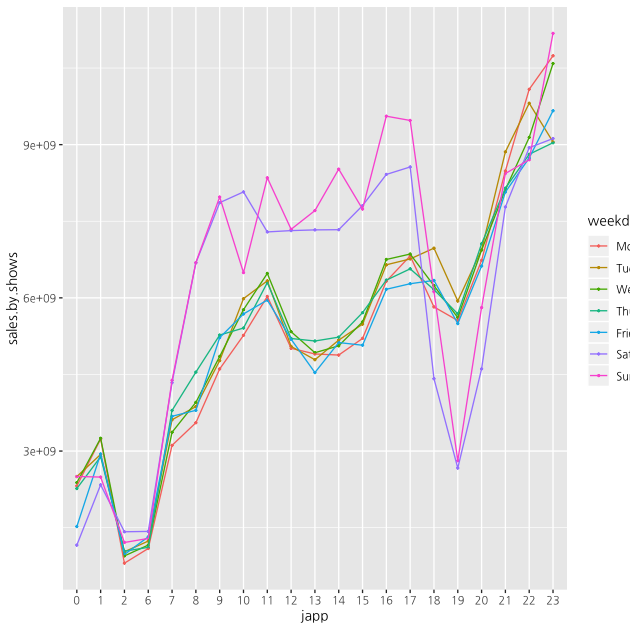

In [24]:
hshop.sales %>%
  select(japp, sales, weekday) %>%
  group_by(japp, weekday) %>%
  summarise(sales.by.shows = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=japp,y=sales.by.shows, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

주말 19시 - 저녁먹을때/주말드라마 전에는 매출이 급격히 감소

아래 주문량 기준과 비교했을 때 peak time은 비슷하나 심야시간대 콜 수가 적은 반면 매출합이 굉장히 크다 --> 단가가 높은 제품을 판매하는 경향이 있다?

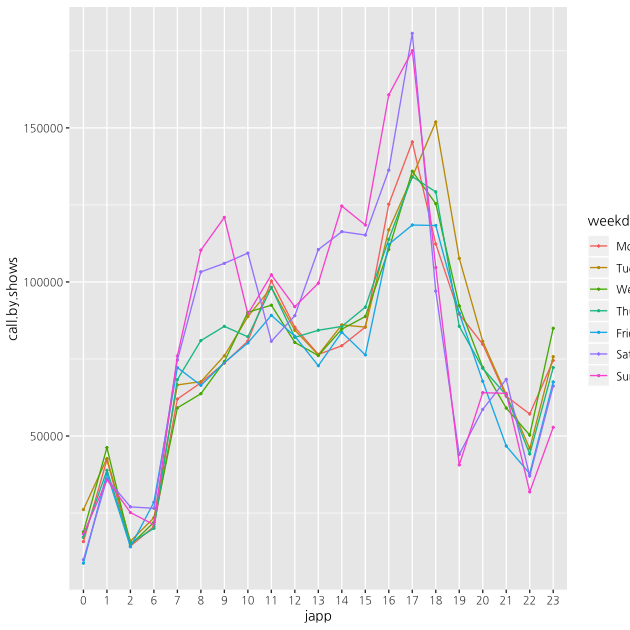

In [27]:
hshop.sales %>%
  select(japp, volume, weekday) %>%
  group_by(japp, weekday) %>%
  summarise(call.by.shows = sum(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=japp,y=call.by.shows, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

# time slot

한 회차 기준 보통 2-3회에 나눠서 방송. 보통 마지막 time slot때 주문량이 급증한다고 하기 때문에 매출액에 연관성이 있지  않을까?

같은 방송 시간에 여러개의 상품코드를 팔 경우 각각 상품코드별로 count.
1-8 사이의 factor 리턴

! 같은 날짜에 다른 시간대로 같은 상품을 파는 경우/같은 타임에 방송했는데 마더코드가 다른 상품을 파는 경우 존재,

In [19]:
# 한 time slot별로 그룹화(row가 방송1 timeslot)
# 이후 show.id, bp구할 때 용이하게끔
ts.schedule <- hshop.sales %>%
  mutate(ymd = format(방송일시, "%Y-%m-%d")) %>%
  group_by(방송일시) %>%
  filter(row_number() == 1)%>%
  as.data.frame


# time slot(parttime)
library(data.table)
ts.schedule <- transform(ts.schedule, parttime = ave(마더코드, rleid(ymd,마더코드), FUN = seq_along))
hshop.sales$parttime <- NA
for(i in 1:nrow(ts.schedule)){
  timeslot <- ts.schedule$방송일시[i]
  part <- ts.schedule$parttime[i]
  hshop.sales$parttime[hshop.sales$방송일시 == timeslot] <- part
}

In [20]:
hshop.sales$parttime <- as.factor(hshop.sales$parttime) #factor

In [22]:
head(hshop.sales)

방송일시,노출.분.,마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,hour,weekday,sales,volume,sales.power,parttime
2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"2,099,000",1,1,6,Tuesday,2099000,52.60652,NA,1
2019-01-01 06:00:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"4,371,000",1,1,6,Tuesday,4371000,109.54887,NA,1
2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"3,262,000",1,1,6,Tuesday,3262000,81.75439,NA,2
2019-01-01 06:20:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"6,955,000",1,1,6,Tuesday,6955000,174.31078,NA,2
2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"6,672,000",1,1,6,Tuesday,6672000,167.21805,NA,3
2019-01-01 06:40:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"9,337,000",1,1,6,Tuesday,9337000,234.01003,NA,3


# show.id

일별 방송 회차. ex 2019년 10월 10일 4번째 방송 --> "2019-10-10 4" 형태로 리턴

In [28]:
ts.schedule$show.counts <- NA

In [29]:
for(i in unique(ts.schedule$ymd)){
  rtn <- ts.schedule[ts.schedule$ymd == i,]
  slot.count <- 0 #num of shows for each day
  for(j in 1:nrow(rtn)){
    if(rtn$parttime[j] == 1){
      slot.count <- slot.count + 1 #cum num of shows
      ts.schedule[ts.schedule$ymd == i,]$show.counts[j] <- paste(i, slot.count) #exp like "2019-01-01 1"
    }}
}

In [30]:
head(ts.schedule$show.counts)

[1] "2019-01-01 1" NA             NA             "2019-01-01 2" NA            
[6] NA

assign show.id only to the rows with parttime == 1, meaning the first time slot for each product                                                   

# min.range

위에서  구한 show.id 별 방송 길이

In [31]:
ts.schedule$min.range <- NA
for(i in 1:(nrow(ts.schedule))){
  if(ts.schedule$parttime[i] == 1){
    min.dur <- ts.schedule$노출.분.[i] # min for each time slot
    j <- i + 1
    while(ts.schedule$parttime[j] != 1){
      min.dur <- min.dur + ts.schedule$노출.분.[j]
      j <- j + 1
      if(j == nrow(ts.schedule)+1) break
    }
  }
  ts.schedule$min.range[i:(j-1)] <- min.dur
}

In [32]:
head(ts.schedule$min.range)

[1] 60 60 60 60 60 60

In [33]:
#show.id랑 min.range hshop.sales 파일에 통합
hshop.sales$min.range <- NA
hshop.sales$show.id <- NA
for(i in which(!is.na(ts.schedule$show.counts))){

  show.id <- ts.schedule$show.counts[i]
  timeslot <- ts.schedule$방송일시[i]
  minrange <- ts.schedule$min.range[i]
    
  hshop.sales$show.id[hshop.sales$방송일시 >= timeslot & 
                            hshop.sales$방송일시 < timeslot + 60*minrange] <- show.id 
    #time으로 같은 회차임을 판별, 해당하는값 삽입
  hshop.sales$min.range[hshop.sales$방송일시 >= timeslot & 
                          hshop.sales$방송일시 < timeslot + 60*minrange] <- minrange
}

In [35]:
head(hshop.sales[,c(1,3,4,5,16,17,18,19)])

방송일시,마더코드,상품코드,상품명,parttime,japp,min.range,show.id
2019-01-01 06:00:00,100346,201072,테이트 남성 셀린니트3종,1,6,60,2019-01-01 1
2019-01-01 06:00:00,100346,201079,테이트 여성 셀린니트3종,1,6,60,2019-01-01 1
2019-01-01 06:20:00,100346,201072,테이트 남성 셀린니트3종,2,6,60,2019-01-01 1
2019-01-01 06:20:00,100346,201079,테이트 여성 셀린니트3종,2,6,60,2019-01-01 1
2019-01-01 06:40:00,100346,201072,테이트 남성 셀린니트3종,3,7,60,2019-01-01 1
2019-01-01 06:40:00,100346,201079,테이트 여성 셀린니트3종,3,7,60,2019-01-01 1


# waiting time till the next event(vol+1)

 = 방송시간(min.range)/판매수량(volume) 

낮을수록 구매가 활발히 일어남. 상품코드별 distinct

In [36]:
hshop.sales$sales.power <- NA
for (i in unique(hshop.sales$상품코드)){
  min.dur <- hshop.sales %>%
    filter(상품코드 == i)%>%
    group_by(show.id) %>%
    filter(row_number() == 1)%>%
    ungroup()%>%
    summarise(min.dur = sum(min.range, na.rm  = TRUE))%>% as.numeric()
  
  tot.amnt <- hshop.sales %>%
    filter(상품코드 == i) %>%
    summarise(tot.sales = sum(volume, na.rm = TRUE))%>% as.numeric()
  
  hshop.sales$sales.power[hshop.sales$상품코드 == i] <- min.dur/tot.amnt
}

In [37]:
hshop.sales

방송일시,노출.분.,마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,hour,weekday,sales,volume,sales.power,parttime,japp,min.range,show.id
2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"2,099,000",1,1,6,Tuesday,2099000,52.60652,0.13369970,1,6,60,2019-01-01 1
2019-01-01 06:00:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"4,371,000",1,1,6,Tuesday,4371000,109.54887,0.07223942,1,6,60,2019-01-01 1
2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"3,262,000",1,1,6,Tuesday,3262000,81.75439,0.13369970,2,6,60,2019-01-01 1
2019-01-01 06:20:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"6,955,000",1,1,6,Tuesday,6955000,174.31078,0.07223942,2,6,60,2019-01-01 1
2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,"6,672,000",1,1,6,Tuesday,6672000,167.21805,0.13369970,3,7,60,2019-01-01 1
2019-01-01 06:40:00,NA,100346,201079,테이트 여성 셀린니트3종,의류,39900,"9,337,000",1,1,6,Tuesday,9337000,234.01003,0.07223942,3,7,60,2019-01-01 1
2019-01-01 07:00:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,"6,819,000",1,1,7,Tuesday,6819000,115.57627,0.04565121,1,7,60,2019-01-01 2
2019-01-01 07:20:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,"15,689,000",1,1,7,Tuesday,15689000,265.91525,0.04565121,2,7,60,2019-01-01 2
2019-01-01 07:40:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,"25,370,000",1,1,7,Tuesday,25370000,430.00000,0.04565121,3,8,60,2019-01-01 2
2019-01-01 08:00:00,20,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,"16,133,000",1,1,8,Tuesday,16133000,269.33222,0.02776187,1,8,60,2019-01-01 3


In [38]:
# low
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange(desc(sales.power)) %>%
  select(상품코드,  상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()


상품코드,상품명,상품군,sales.power,판매단가
201559,무)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2394.0,3990000
201564,일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201555,(일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201556,(일)한샘 하이바스 내추럴 하부장형,가구,1992.6,3321000
201554,(일)한샘 하이바스 내추럴 기본형 + 키큰장,가구,1992.6,3321000
200536,일시불 LG 휘센 싱큐 에어컨 2IN1형 FQ19V9KWA2,가전,1475.4,2459000
201762,일시불 삼성 무풍클래식 스탠드에어컨 AF17R7573WZK,가전,843.6,2109000
200492,무이자 LG트롬 건조기 14kg RH14VN(실버),가전,756.0,1890000
200559,일시불 LG트롬 건조기 14kg RH14VN(실버),가전,720.0,1800000
200560,일시불 LG트롬 건조기 14kg RH14WN(화이트),가전,680.0,1700000


In [39]:

# high
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange((sales.power)) %>%
  select(상품코드, 상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()



상품코드,상품명,상품군,sales.power,판매단가
202064,고창 꿀 고구마 10kg,농수축,0.006532835,30900
201634,완도꼬마활전복 1.3kg,농수축,0.007869326,29900
200125,고칼슘검은콩두유48팩+호두아몬드 두유48팩,농수축,0.010037787,30900
201486,피시원 국내산 절단 햇 꽃게 2.4kg,농수축,0.010304382,49900
201036,LG생활건강 샤프란아우라 고농축 섬유유연제,생활용품,0.010408158,30900
200664,오델로 겨울모자 3종 (2차),잡화,0.010960897,29800
201955,영산포숙성홍어회7팩,농수축,0.010983615,29900
201322,코몽트 덤블 플리스 자켓 2종,의류,0.011086997,39900
201487,피시원 국내산 절단 햇 꽃게 7팩,농수축,0.011092600,49900
202063,강원도양구 간편시래기15팩,농수축,0.011727942,30900


단가가 낮아야 waiting time이 확실히 감소

# freq items 

방송 횟수가 잦은 상품들. 방송횟수 기준 탑 10의 상품코드

In [114]:

hshop.sales %>%
  group_by(상품코드) %>%
  mutate(n.shows = n_distinct(show.id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(n.shows)) %>%
  head(10) %>%
  select(상품코드, 상품명, 상품군, n.shows) %>%
  as.data.frame()
# 간고등어, 한일대용량 믹서기, 세탁기

상품코드,상품명,상품군,n.shows
200864,안동간고등어 20팩,농수축,106
200868,한일 대용량 스텐 분쇄믹서기,주방,94
200533,일시불 LG 통돌이 세탁기,가전,92
200465,무이자 LG 통돌이 세탁기,가전,92
200014,AAB의 소곱창전골 800g x 8팩,농수축,84
202510,멋진밥상 흥양농협 쌀 20kg,농수축,73
200236,에코라믹 통주물 스톤 냄비세트,주방,66
200556,일시불 LG전자 매직스페이스 냉장고,가전,64
200489,무이자 LG전자 매직스페이스 냉장고,가전,64
202467,무이자 쿠쿠전기밥솥 10인용(CRP-QS107FG/FS),주방,63


In [134]:
hot.list <- hshop.sales %>%
  group_by(상품코드) %>%
  mutate(n.shows = n_distinct(show.id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(n.shows)) %>%
  head(10) %>%
  select(상품코드) %>%
  as.list()

In [135]:
hshop.sales$hottest  <- NA
hshop.sales$hottest <- ifelse(hshop.sales$상품코드 %in% hot.list$상품코드, 1, 0)

In [137]:
hshop.sales[hshop.sales$hottest == 1,] #freq items

,방송일시,노출.분.,마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,weekday,sales,amnt,japp,parttime,min.range,show.id,sales.power,hottest
21,2019-01-01 12:00:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,"33,823,000",1,1,Tuesday,33823000,555.38588,12,1,60,2019-01-01 7,0.02896111,1
22,2019-01-01 12:20:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,"59,083,000",1,1,Tuesday,59083000,970.16420,12,2,60,2019-01-01 7,0.02896111,1
23,2019-01-01 12:40:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,"99,235,000",1,1,Tuesday,99235000,1629.47455,13,3,60,2019-01-01 7,0.02896111,1
45,2019-01-01 20:00:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,"35,519,000",1,1,Tuesday,35519000,80.90888,20,1,60,2019-01-01 16,0.29974294,1
46,2019-01-01 20:00:00,NA,100150,200465,무이자 LG 통돌이 세탁기,가전,489000,"19,123,000",1,1,Tuesday,19123000,39.10634,20,1,60,2019-01-01 16,0.40765057,1
47,2019-01-01 20:20:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,"56,859,000",1,1,Tuesday,56859000,129.51936,20,2,60,2019-01-01 16,0.29974294,1
48,2019-01-01 20:20:00,NA,100150,200465,무이자 LG 통돌이 세탁기,가전,489000,"58,685,000",1,1,Tuesday,58685000,120.01022,20,2,60,2019-01-01 16,0.40765057,1
49,2019-01-01 20:40:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,"68,320,000",1,1,Tuesday,68320000,155.62642,21,3,60,2019-01-01 16,0.29974294,1
50,2019-01-01 20:40:00,NA,100150,200465,무이자 LG 통돌이 세탁기,가전,489000,"46,068,000",1,1,Tuesday,46068000,94.20859,21,3,60,2019-01-01 16,0.40765057,1
111,2019-01-02 15:00:00,20,100253,200864,안동간고등어 20팩,농수축,30900,"41,722,000",1,2,Wednesday,41722000,1350.22654,15,1,60,2019-01-02 12,0.01365513,1


# 요일+시간 vs 168시간/주

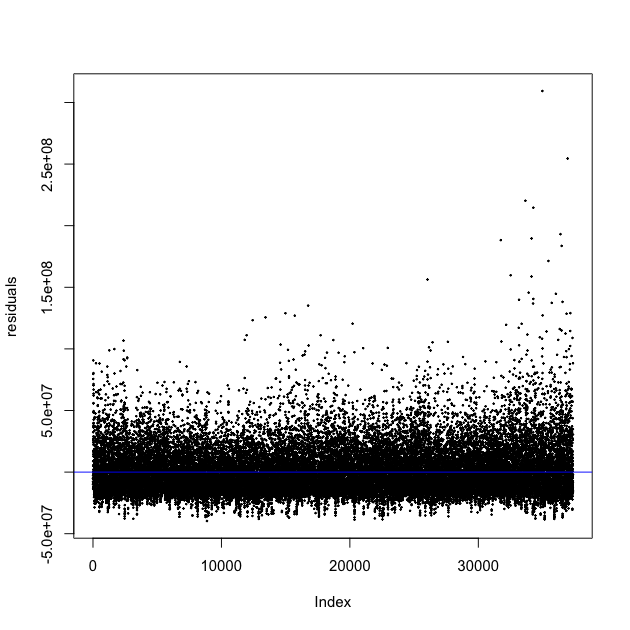

In [142]:
# weekday + hr
hshop.sales$hour <- as.factor(hour(hshop.sales$방송일시))
fit1 <- lm(sales ~ hour+weekday, data = hshop.sales)
plot(fit1$residuals, type = "p", cex = 0.2,  ylab = "residuals")
abline(h = 0, col = "blue")

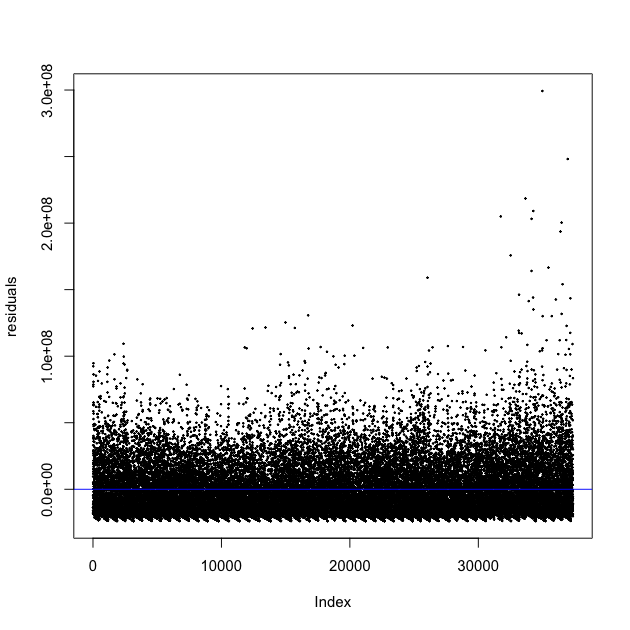

In [143]:
#168시간
hshop.sales$weekhr <- as.numeric(hshop.sales$weekday)*24-24+as.numeric(as.character(hshop.sales$hour))
fit2 <- lm(sales ~ weekhr, data = hshop.sales)
plot(fit2$residuals, type = "p", cex = 0.2,  ylab = "residuals")
abline(h = 0, col = "blue")


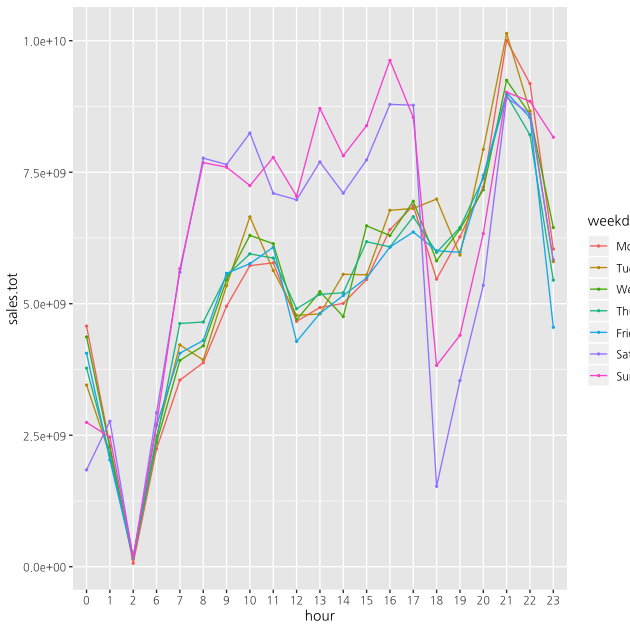

In [144]:
hshop.sales %>%
  group_by(hour, weekday) %>%
  summarise(sales.tot = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=hour,y=sales.tot, group = weekday, color = weekday)) + 
  geom_point(size=0.5) +
  geom_line()

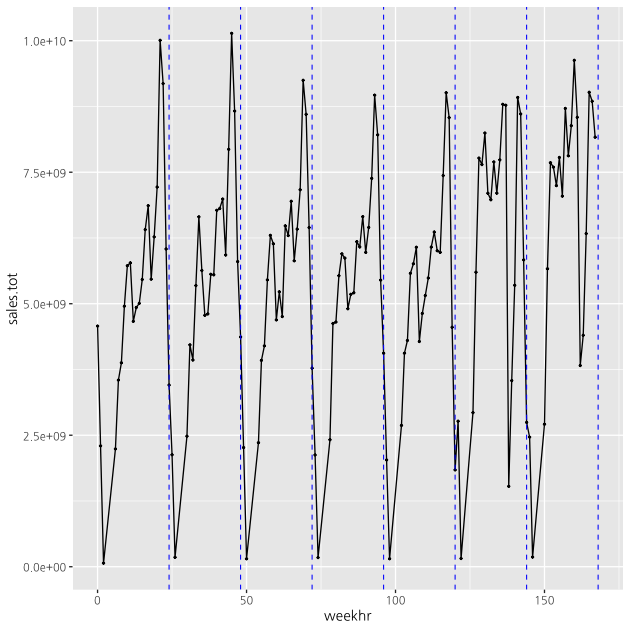

In [156]:
hshop.sales %>%
  group_by(weekhr) %>%
  summarise(sales.tot = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=weekhr,y=sales.tot)) + 
  geom_point(size=0.5) +
  geom_line() + 
  geom_vline(xintercept = 24*(1:7), linetype="dashed", 
                color = "blue", size=0.4)